In [1]:
import pandas as pd
import json
from itertools import chain
import spacy
import numpy as np
from difflib import SequenceMatcher

This section includes code to generate a score for the following questions:

Is the first name realistic?

Is the last name realistic? 

Do the name and email address match?

Is this filer's name a celebrity name?

Does the filer name and address information match that of an impersonated person?

Is the comment from a form letter?

Was the filer's email address involved in a breach?

Did the filer opt for email confirmation?

Did the filer supply complete address information?

Do the filer's name and email address match those of any other filer(s)?


In [139]:
# load first 10,000 comments 
data = pd.DataFrame.from_csv('modified_ecfs_17-108_0.csv')

In [23]:
# check to see if names are proper nouns, and if they refer to a person
#note -- will need to fine-tune this. spacy is only right 85% of the time (see NER accuracy: https://spacy.io/models/en#en_core_web_md)
nlp = spacy.load('en', entity=True) # load English module in spaCy

In [24]:
%time
first_name_obj = [nlp(i) if type(i) is str else nlp(' ') for i in chain(data['first_name'])]
middle_name_obj = [nlp(i) if type(i) is str else nlp(' ') for i in chain(data['middle_name'])]
last_name_obj = [nlp(i) if type(i) is str else nlp(' ') for i in chain(data['last_name'])]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [25]:
city_obj = [nlp(i) if type(i) is str else nlp(' ') for i in chain(data['city'])]

In [30]:
city_score = [1 if i[0].pos_ == 'SPACE' or i[0].ent_type_ == 'PROPN GPE' or i[0].ent_type == 'NOUN GPE' else 0 
 for i in chain(city_obj)]

In [163]:
# feature scores for names (check part of speech tag)
# not using middle names because most people don't provide middle name
first_name_score = [1 if i[0].pos_ == 'PROPN'  or i[0].ent_type_ == 'PERSON' else 0 for i in chain(first_name_obj)]
last_name_score = [1 if i[0].pos_ == 'PROPN' or i[0].ent_type_ == 'PERSON' else 0 for i in chain(last_name_obj)]

In [31]:
# check similarity between email addresses and names by counting number of instances of characters in each 
# convert names and email addresses to lowercase to facilitate comparision
# eliminate '@' and everything after 
valid_emails = [i.lower() if type(i) is str else '@ ' for i in chain(data['email'])]

In [32]:
email_split = [email.partition('@') for email in chain(valid_emails)]
email_head = [head[0] for head in chain(email_split)]

In [33]:
# combine names to make full name
names = [str(name).lower() for name in data['first_name']+ data['middle_name'] +data['last_name']]

In [34]:
def similar(arr):
    string1 = arr[0].lower(); string2 = arr[1].lower()
    return SequenceMatcher(None, string1, string2).ratio()

In [35]:
email_name_arr = np.vstack([email_head,names]).T
email_match_score = [similar(row) for row in email_name_arr]
email_match = [1 if score > 0.5 else 0 for score in email_match_score]

In [11]:
# for celeb match, examine those between 0.4 and 0.5 and take those > 0.5 as matches. something as small as a space 
# in between can change match by as much as 10%
with open("celebs.txt") as file:
    text = file.readlines()
content = [x.strip('\n') for x in text] 
celebs = [i for i in content if i != '']
celeb_match_score = [[similar([name,celeb]), name, celeb] for name in names 
               for celeb in celebs if similar([name, celeb]) > 0.85]

In [36]:
celeb_match = [0 if name in chain(np.array(celeb_match_score)[:,1]) else 1 for name in names]

In [37]:
# check for imposters
with open("impersonated.txt") as file:
    text = file.readlines()
impersonated = [x.strip('\n') for x in text] 
impersonated = [i.split(',') for i in chain(impersonated) if i[0] != None] # none = empty lines at end of file

%time
# need to optimize for speed 
# cutoff of 0.85 obtained by inspection 
similar_person = [[similar([person,imposter]), person, imposter] for imposter in chain(names) 
                  for person in chain(pd.DataFrame(impersonated)[0])
                  if similar([person, imposter]) > 0.85]

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs


In [38]:
# check city for those whose names match impersonated people
person_index = [names.index(i) for i in chain(pd.DataFrame(similar_person)[2])]
valid_city = [i if type(i) is str else ' ' for i in chain(data['city'])] # get rid of nans
person_city = [(valid_city[i]) for i in chain(person_index)]
similar_city = [[similar([person_city,imposter_city]), person_city, imposter_city] 
                for person_city in chain(pd.DataFrame(impersonated)[1])
                for imposter_city in person_city 
                if similar([person_city, imposter_city]) > 0.85]

In [39]:
# check state for those whose names match impersonated people
valid_state = [i if type(i) is str else ' ' for i in chain(data['state'])]
person_state = [(valid_state[i]) for i in chain(person_index)]
similar_state = [[similar([person_state,imposter_state]),person_state, imposter_state] 
                  for person_state in chain(pd.DataFrame(impersonated)[2])
                  for imposter_state in person_state 
                  if similar([person_state, imposter_state]) > 0.85]

In [40]:
# no impersonators for this set, so just assign appropriate score to all 
# need to generalize code for other FCC comment files
imposter_match = np.repeat(1, len(names))

In [41]:
# check to see if comment is from form letter using both spaCy (semantic similarity) 
# and SequenceMatcher (number of occurences of each letter)
# Using both because the spacy scores are sometimes unrealistically high 
with open("form_letters.txt") as file:
    text = file.readlines()
content = [x.strip() for x in text] 
form_letters = [i for i in content if "Source:" not in i and i != '']

In [159]:
len(form_letters)

25

In [42]:
# some of the rows have comments in text_data or text_data_docs, but not both (it seems)
text_data_docs_supplied = np.where(data['text_data'] == " ")
valid_text = [i for i in chain(data['text_data'])]
for i in range(len(text_data_docs_supplied)):
    valid_text[i] = data['text_data_docs'][i]

In [44]:
# check similarity using SequenceMatcher, 0.5 cutoff obtained by inspection
%time
SM_flscore = [[similar([fl, data]), fl, data, valid_text.index(data), names[valid_text.index(data)]] 
            for fl in form_letters for data in valid_text if similar([fl, data]) > 0.6]

CPU times: user 2 µs, sys: 13 µs, total: 15 µs
Wall time: 5.01 µs


In [45]:
# check similarity to most duplicated comments
with open("top_comments.txt") as file:
    text = file.readlines()                                             
    top_comments = [x.strip('\n') for x in text]                        

In [47]:
SM_topscore = [[similar([top, data]), top, data, valid_text.index(data), names[valid_text.index(data)]] 
            for top in top_comments for data in valid_text if similar([top, data]) > 0.6]

In [61]:
# SM_score has lots of duplicates, so we want only the unique indices 
#uniq = list(np.unique(pd.DataFrame(SM_score)[3]))

In [ ]:
# check using spacy
#%time
#fl_obj = [nlp(i) for i in chain(form_letters)]
#data_obj = [nlp(i) for i in chain(valid_text)]
#spacy_score = [text1.similarity(text2) for text1 in fl_obj for text2 in data_obj]

In [48]:
# spacy score is more indicative of stance, rather than semantic similarity, so only using SM score for now
form_letter_match = [0 if name in chain(pd.DataFrame(SM_flscore)[4]) else 1 for name in names]

In [49]:
top_comment_match = [0 if name in chain(pd.DataFrame(SM_topscore)[4]) else 1 for name in names]

In [50]:
breach_match = [0 if status_code == 200 else 1 for status_code in chain(data['status_code'])]
email_confirmation = [1 if email_conf == True else 0 for email_conf in chain(data['email_confirmation'])]

In [51]:
# give good score if complete address information or international (need to figure out how to separate in to zip, etc)
# address is supplied, bad score if not. 
addline1 = [1 if type(line) is str and line != " " else 0 for line in chain(data['address_line_1'])]
addline2 = [1 if type(line) is str and line != " " else 0 for line in chain(data['address_line_2'])]
addcity = [1 if type(line) is str and line != " " else 0 for line in chain(data['city'])]
addstate = [1 if type(line) is str and line != " " else 0 for line in chain(data['state'])]
addzip = [1 if type(line) is str and line != " " else 0 for line in chain(data['zip5'])]

In [63]:
# check similarity of email and address to others in dataset 
email_sm = [[similar([email1, email2]), email1, email2, valid_emails.index(email2)] 
            for email1 in valid_emails for email2 in valid_emails if similar([email1, email2]) > 0.8]

In [62]:
add_sm = [[similar([add1, add2]), add1, add2, names[list(data['address_line_1']).index(add1)]]
            for add1 in chain(data['address_line_1']) for add2 in chain(data['address_line_1']) 
          if similar([add1, add2]) > 0.8]

0

In [69]:
email_copy = [0 if email in chain(pd.DataFrame(email_sm)[1]) else 1 for email in valid_emails]

In [ ]:
add_copy = [0 if name in chain(pd.DataFrame(add_sm)[3]) else 1 for name in names]

In [54]:
# constructing the prior, informed by previous studies (about 10% of the comments are unique)
import matplotlib.pyplot as plt
from scipy.stats import beta, binom
%matplotlib inline

In [56]:
# set plotting area
fig = plt.figure()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 5)
fig.subplots_adjust(hspace=0.4, wspace=.25)

Text(0.5,1,'Prior Distribution on Comment Uniqueness')

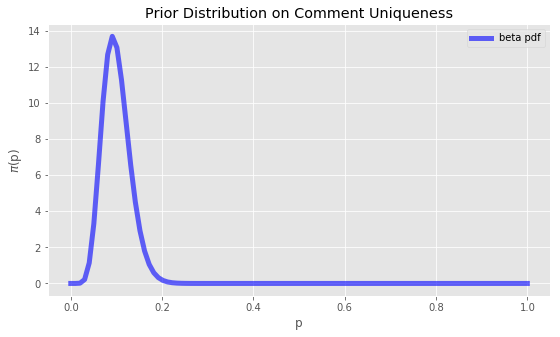

In [57]:
a = 10 ## alpha parameter
b = 90 ## beta parameter
prob = np.linspace(0,1, 100)
plt.plot(prob, beta.pdf(prob, a, b),'b-', lw=5, alpha=0.6, label='beta pdf')
plt.xlim=(0, 1)
plt.xlabel('p')
plt.ylabel('$\pi$(p)')
plt.legend()
plt.title('Prior Distribution on Comment Uniqueness')

In [153]:
# compute parameters for binomial likelihood 
# n = number of successes 
# p = probability that comment is unique
N = 13 # number or trials (yes/no questions)
n = np.array(first_name_score) + np.array(last_name_score) + np.array(email_match) + np.array(celeb_match)\
 + np.array(form_letter_match) + np.array(breach_match) + np.array(email_confirmation)\
     + np.array(addline1)+np.array(addline2)+np.array(addcity) + np.array(addstate) + \
    np.array(addzip) + np.array(email_copy)
p = np.divide(n,N)

Text(0.5,0,'n')

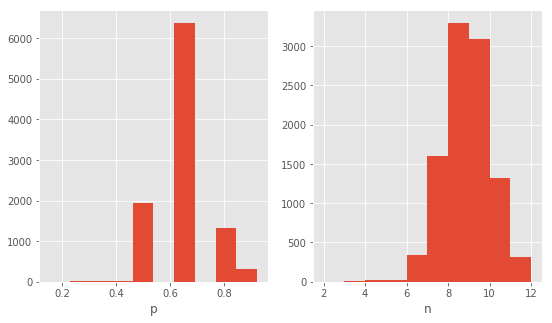

In [154]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(p)
ax1.set_xlabel('p')
ax2.hist(n)
ax2.set_xlabel('n')

In [94]:
len(p[p > 0.8])/len(p)

0.029705941188237647

Most of the comments seem to be unique (passed most of the questions). I thought the reason for this is the set-up of our model -- those with unavailable information (i.e. whether first name and last name were realistic) were also given high scores, but when I eliminated less informative scores like that, the distribution of the posterior means remained largely unchanged. This tells us that the model is too simplistic, because it is not able to discriminate between those with complete information and those without.

In [117]:
# compute posterior means using conjugacy
a_prime = a + np.sum(prob)
b_prime = b + n - np.sum(prob) 
pm = a_prime/(a_prime + b_prime)

Text(0.5,0,'posterior means')

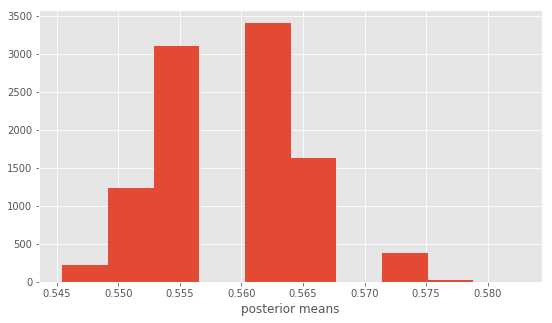

In [118]:
plt.hist(pm)
plt.xlabel('posterior means')

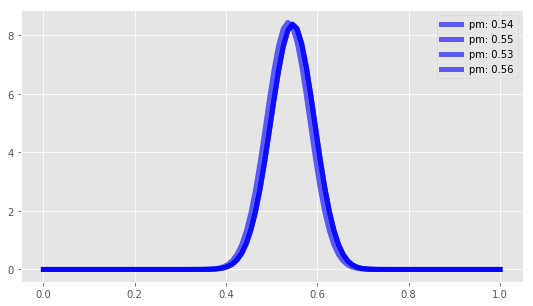

In [319]:
# for a random selection of comments, see if posterior means makes sense. 
import random
rand_index = np.random.randint(0, len(b_prime)-1, 5)
for i in range(4):
    plt.plot(prob, beta.pdf(prob, a_prime, b_prime[rand_index[i]]),
               'b-', lw=5, alpha=0.6, label='pm: '+str("%.2f" % pm[i]))
    plt.legend()

In [158]:
# take a look at the profiles 
for i in range(len(data[data['cluster_id']==35])):
    print('Name:'+ data['first_name'][i]+' ' + data['middle_name'][i]\
          + data['last_name'][i])
    print('Email:'+ data['email'][i])
    print('Address:'+ str(data['address_line_1'][i])+' '\
         +str(data['address_line_2'][i])+'\n'\
          +str(data['city'][i])+' '+ str(data['state'][i])\
         +' '+ str(data['zip5'][i]))
    print('Breached: '+ str(breach_match[i+1]))
    print('p: ' + str(p[i]))
    print('Email confirmation: ',str(data['email_confirmation'][i]))
    print('Comment:', data['text_data'][i]+"\n")
    

Name:Zachary  Buchan
Email:perfusionman@gmail.com
Address:5188 Manor Brook Rd NW  
Rochester MN 55901
Breached: 0
p: 0.769230769231
Email confirmation:  nan
Comment: Guys, I seriously don't understand your reasoning here. By killing net neutrality, you're basically giving ISPs the right to decide what I can see on the internet. What are we going to do if all of a sudden Comcast or Verizon decides that they want to charge Republican-leaning websites more than liberal ones? Or if, say, Burger King gives them some large amount of money to slow down McDonald's websites? The possibilities for abuse are endless, especially given the pretty fishy business practices most ISPs are known to engage in. 

And I don't at all understand how this is supposed to help the consumer. You've said that maybe they could raise money by charging companies more for better speed, and then they could pass that on to the rest of us via lower prices, but I just don't buy that argument. History pretty clearly shows

TypeError: must be str, not float

In [120]:
# read in cluster ids and create new data frame with ids and posterior means
# load Tarini's cluster IDs and silhouette scores  
clustered = pd.DataFrame.from_csv('fcc_comments_cluster_silmean.csv')

In [141]:
data['p'] = p
data['n'] = n
data['pm'] = pm

# truncate to match Tarini's
data=data.drop(data.index[0]).reset_index(drop=True)

In [136]:
del(data['address_line_2'])

In [142]:
data['cluster_id'] = clustered['cluster_id']
data['silscore'] = clustered['silhouette_score']
data['stance'] = clustered['net neutrality']
data['mean_sil_score'] = clustered['mean silhouette score']

In [377]:
data.to_csv('analyzed_ecfs_17-108_0.csv')

In [137]:
data[data['cluster_id']==35]

,address_line_1,city,email,email_confirmation,first_name,last_name,middle_name,state,text_data,text_data_docs,...,zip4,zip5,breach,p,n,pm,cluster_id,silscore,stance,mean_sil_score
1290,105w.Phillip Ave,Omaha,FASTTRUCKER2006@YAHOO.COM,NaN,Ronald,Tucker,,NE,I was outraged by the Obama/Wheeler FCC's deci...,,...,68157,68157,"[{""Title"":""MySpace"",""Name"":""MySpace"",""Domain"":...",0.454545,5,0.571429,35,0.999872,0,0.999745
1291,5614 Chapin Ave,Alexandria,JEFFBH62@HOTMAIL.COM,NaN,JEFFERY,HASKINS,,VA,I was outraged by the Obama/Wheeler FCC's deci...,,...,22303,22303,"[{""Title"":""Dailymotion"",""Name"":""Dailymotion"",""...",0.545455,6,0.566038,35,0.999872,0,0.999745
1292,3118 Worthington Ave,Bakersfield,KELLI19WILSON@GMAIL.COM,NaN,Kelli,Wilson,,CA,I was outraged by the Obama/Wheeler FCC's deci...,,...,93308,93308,NaN,0.818182,9,0.550459,35,0.999872,0,0.999745
1293,3435 Arsenal,Fargo,SUK.MONGER19@GMAIL.COM,NaN,Suk,Monger,,ND,I was outraged by the Obama/Wheeler FCC's deci...,,...,58103,58103,"[{""Title"":""Modern Business Solutions"",""Name"":""...",0.636364,7,0.560748,35,0.999872,0,0.999745
1294,191 Pasture Dr,Union,GADAMS809@GMAIL.COM,NaN,Linda,Adams,,SC,I was outraged by the Obama/Wheeler FCC's deci...,,...,29379,29379,"[{""Title"":""Modern Business Solutions"",""Name"":""...",0.545455,6,0.566038,35,0.999872,0,0.999745
1295,7 Trout Dr,Heber Springs,MBRAWLEY12@GMAIL.COM,NaN,Mike,Brawley,,AR,I was outraged by the Obama/Wheeler FCC's deci...,,...,72543,72543,"[{""Title"":""Modern Business Solutions"",""Name"":""...",0.727273,8,0.555556,35,0.999872,0,0.999745
1296,1113 Tribbett Ave,Sharon Hill,TRISHLANE4281@GMAIL.COM,NaN,Patricia,Lane,,PA,I was outraged by the Obama/Wheeler FCC's deci...,,...,19079,19079,"[{""Title"":""Modern Business Solutions"",""Name"":""...",0.636364,7,0.560748,35,0.999872,0,0.999745
1297,902 Wilson Ave,Marion,WILLIAMS.COURTNIE11@YAHOO.COM,NaN,Courtnie,Williams,,OH,I was outraged by the Obama/Wheeler FCC's deci...,,...,43302,43302,NaN,0.727273,8,0.555556,35,0.999872,0,0.999745
1298,6818 Blue Lake Dr,San Antonio,IDAPIE007@YAHOO.COM,NaN,ida,scott,,TX,I was outraged by the Obama/Wheeler FCC's deci...,,...,78244,78244,"[{""Title"":""LinkedIn"",""Name"":""LinkedIn"",""Domain...",0.454545,5,0.571429,35,0.999872,0,0.999745
1299,514 E Harden St Apt A,Graham,BATONROUGELADY29@GMAIL.COM,NaN,Julie,Baldwin,,NC,I was outraged by the Obama/Wheeler FCC's deci...,,...,27253,27253,"[{""Title"":""Modern Business Solutions"",""Name"":""...",0.636364,7,0.560748,35,0.999872,0,0.999745
